In [1]:
import numpy as np
%tensorflow_version 2.x # only for colab
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
# COMMENT OUT THIS LINE FOR COLAB!
# %matplotlib notebook
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # only for colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.3.0


# 1 Data set
We will work with the Tensorflow **Malaria dataset** https://www.tensorflow.org/datasets/catalog/malaria.

It  contains  27.558  coloured  images  of  cells  with  equal  shares  of malaria-infected cells and uninfected cells. First, we **load the data**, together with the information provided ("with_info=True", but this is not strictly necessary).

We have a look at a few samples presented in a dataframe using the provided "info" and a tensorflow datasets convenience function.

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete0FHPUQ/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


,image,label
0,,1 (uninfected)
1,,1 (uninfected)
2,,0 (parasitized)

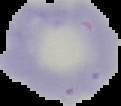
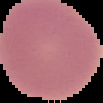
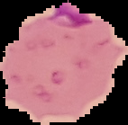

In [2]:
# load the dataset
dataset, info = tfds.load('malaria', as_supervised=True, split = 'train', with_info = True, shuffle_files = True)
# we can use the info we downloaded to get a glimpse of a few images from the dataset
tfds.as_dataframe(dataset.take(3), info)

We print out some of the images together with their shapes.  Do we see a problem here?

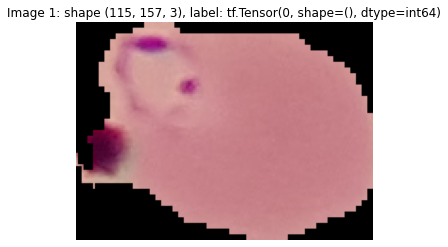

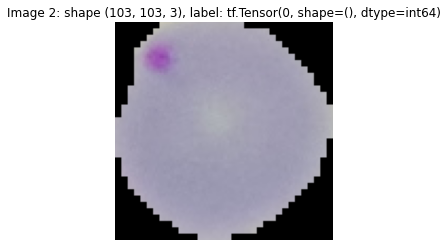

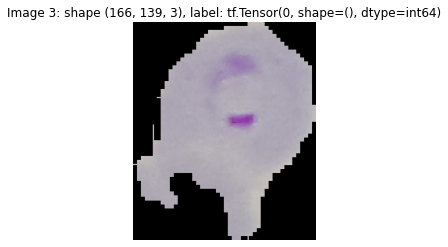

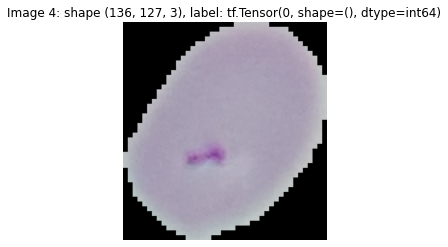

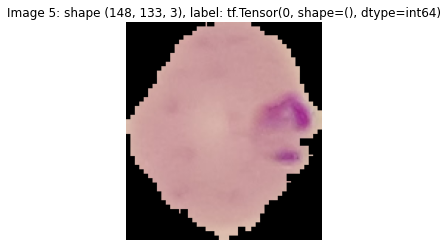

In [3]:
for i, (image, label) in enumerate(dataset.take(5)):  # example is (image, label)
  title = "Image " + str(i+1) + ": shape " + str(image.shape) + ", label: " + str(label)
  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.set_title(title)
  ax.axis("off")

We can see that the **images have different shapes**. We will reshape them into a uniform size of 128x128 pixels.

Furthermore, we **normalize our data** to values between 0 and 1 by dividing each pixel value in the (resized) image tensors by 255, and **apply one-hot encoding to the labels**.

We print out the minimum and maximum pixel values of a sample image from our preprocessed dataset.



In [4]:
# resize by downsampling(if necessary) and/or padding the undefined parts with zeros (since the background is black as well)
dataset_preprocessed = dataset.map(lambda img, label: (tf.image.resize_with_pad(img, 128, 128)/255,tf.one_hot(label,1)))
# look at min and max pixel value of one sample
for img, label in dataset_preprocessed.take(1):
  print(np.min(img),np.max(img))

0.0 0.7700827


Let's **visualize** whether our transformations worked...

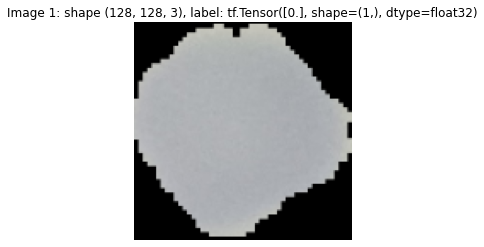

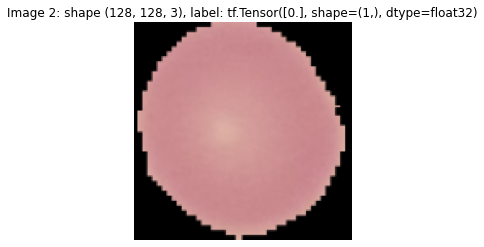

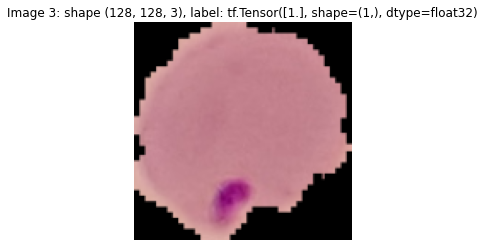

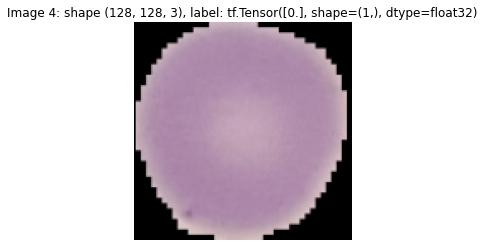

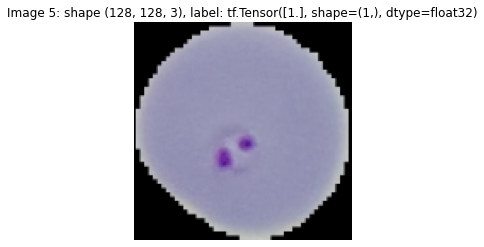

In [5]:
for i, (image, label) in enumerate(dataset_preprocessed.take(5)):  # example is (image, label)
  title = "Image " + str(i+1) + ": shape " + str(image.shape) + ", label: " + str(label)
  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.set_title(title)
  ax.axis("off")

Looks good! **All our images should have the shape (128, 128, 3) now** and **one-hot encoded target labels** of shape (2,). 

Now, we **divide our dataset into training and test data**. We then have a look at how many samples we have in training and test data.


In [6]:
train_dataset = dataset_preprocessed.take(int(len(dataset)*0.8))
test_dataset = dataset_preprocessed.skip(int(len(dataset)*0.8))
print( "No. elements in training dataset before batching: " + str(len(train_dataset)))
print( "No. elements in test dataset before batching: " + str(len(test_dataset)))

No. elements in training dataset before batching: 22046
No. elements in test dataset before batching: 5512


Next, we **shuffle and batch** our data. We can then again inspect individual image shapes and number of elements in training and test data (after batching).

In [7]:
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.shuffle(buffer_size = 64)
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.shuffle(buffer_size = 64)

We have (mini)batches now, thus the number of elements should have decreased in training and test dataset.
The number in the first dimension in the shape of individual images corresponds to the batch size.


In [8]:
print( "No. elements in training dataset after batching: " + str(len(train_dataset)))
for (img,_) in train_dataset:
    print("Shape of a sample training image: " + str(img.shape))
    break;

print( "No. elements in test dataset after batching: " + str(len(test_dataset)))
for (img,_) in test_dataset:
    print("Shape of a sample test image: " + str(img.shape))
    break;

No. elements in training dataset after batching: 345
Shape of a sample training image: (64, 128, 128, 3)
No. elements in test dataset after batching: 87
Shape of a sample test image: (64, 128, 128, 3)


# 2 Model

We now implement a Convolutional Neural Network to classify the cells. We combined some layers, tried different (hyper-)parameter settings and looked what happens. Generally, we wanted to keep the no. parameters of our model small and build a rather deep than wide network architecture in order to prevent from overfitting and making the model generalize better over unseen data (i.e. data not used for training). Finally, we chose the following "settings" which seemed to work quite well:

* 4 x sequence (Conv2D Layer, MaxPool2D Layer)
* Convolutional Layers: 
    * Kernel size = 3x3, 3x3, 5x5, 7x7 
    * with padding and ReLu activation, 
    * dropout rate =	0.25 (via Dropout Layers), 
    * no. filters = 16, 32, 64, 128
* Readout layer = Global Average Pooling
* 2 x hidden (Dense) layers: 
    * activation = ReLU, 
    * dropout rate = 0.5 (via Dropout Layers), 
    * no. neurons: 128, 32
* Output (Dense) layer: 
    * activation = sigmoid, 
    * 1 neuron (activation = 0\~"parasitized" vs. 1\~"uninfected")


In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        #self.conv_0 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same',
        #                                      activation=tf.keras.activations.relu,
        #                                      input_shape=input_shape)
        #self.dropout_0 = tf.keras.layers.Dropout(.25)
        #self.max_pool_0 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                                               activation=tf.keras.activations.relu)
        self.dropout_1 = tf.keras.layers.Dropout(.25)
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same',
                                               strides=(2,2), activation=tf.keras.activations.relu)
        self.dropout_2 = tf.keras.layers.Dropout(.25)
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same',
                                               strides=(3,3), activation=tf.keras.activations.relu)
        self.dropout_3 = tf.keras.layers.Dropout(.25)
        self.max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        # flatten the feature maps
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        # hidden dense layers
        self.dense_1 = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)
        self.dropout_4 = tf.keras.layers.Dropout(.5)
        self.dense_2 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)
        self.dropout_5 = tf.keras.layers.Dropout(.5)
        # output dense layer, one neuron only
        self.output_layer = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

    def call(self, x):
        # Define the forward step.
        #x = self.conv_0(x)
        #x = self.dropout_0(x)
        #x = self.max_pool_0(x)
        x = self.conv_1(x)
        x = self.dropout_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.dropout_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.dropout_3(x)
        x = self.max_pool_3(x)
        x = self.global_pool(x)
        x = self.dense_1(x)
        x = self.dropout_4(x)
        x = self.dense_2 (x)
        x = self.dropout_5 (x)
        x = self.output_layer(x)
        return x

# 3 Training

First, we have to define the train and test step. 

For  training, we take only one minibatch of samples and update the trainable model parameters ((filter) weights and biases).

For testing, we (usually) get the whole test dataset (in minibatches) and calculate the model's prediction accuracy (output compared to target label) to measure how well our model performs with the current parameter values.

In [10]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.mean([1 if np.abs(trgt-pred)<0.5 else 0 for trgt, pred in zip(target, prediction)])
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  
  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = [1 if np.abs(trgt-pred)<0.5 else 0 for trgt, pred in zip(target, prediction)]
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Now we can train our network. As training hyperparameters we will use:

* epochs:  15, one could train even longer as long as the model is not overfitting (we tried to keep our model rather deep and not overly wide to prevent that)
* learning rate:  0.0001
* optimizer:  Adam
* loss:  BinaryCrossEntropy.  Checktf.keras.losses.BinaryCrossentropy()
* accuracy: the mean of how many items in prediction and target are the same (in the batched vectors)

In [11]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: Binary cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=64)
    test_dataset = test_dataset.shuffle(buffer_size=64)

    #training (and checking in with training)
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)
    # glimpse at performance during training
    print('Training accuracy: ' + str(train_accuracies[-1]))

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # glimpse at performance after training, on test data
    print('Test accuracy: ' + str(test_accuracies[-1]))

Epoch: __ 0
Training accuracy: 0.7429655741426885
Test accuracy: 0.7679597701149425
Epoch: __ 1
Training accuracy: 0.8938998553381216
Test accuracy: 0.8999640804597702
Epoch: __ 2
Training accuracy: 0.9191837213335132
Test accuracy: 0.9200790229885057
Epoch: __ 3
Training accuracy: 0.9317160528900577
Test accuracy: 0.9292385057471264
Epoch: __ 4
Training accuracy: 0.9315279249434817
Test accuracy: 0.9295977011494253
Epoch: __ 5
Training accuracy: 0.9446160615812813
Test accuracy: 0.9398347701149425
Epoch: __ 6
Training accuracy: 0.9432972202291479
Test accuracy: 0.9480962643678161
Epoch: __ 7
Training accuracy: 0.95353674896855
Test accuracy: 0.9507902298850575
Epoch: __ 8
Training accuracy: 0.9496045994296107
Test accuracy: 0.9482758620689655
Epoch: __ 9
Training accuracy: 0.9480004368282621
Test accuracy: 0.9552801724137931
Epoch: __ 10
Training accuracy: 0.959839851144085
Test accuracy: 0.9533045977011494
Epoch: __ 11
Training accuracy: 0.951607895737988
Test accuracy: 0.95330459770

# 4 Visualization

We can now visualize accuracy and loss for training and test data using matplotlib.

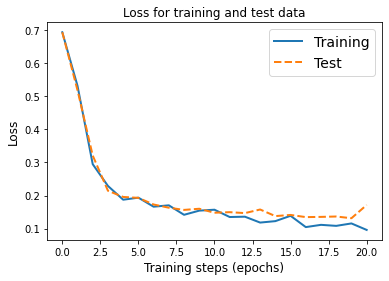

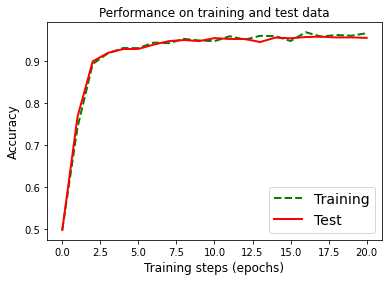

Mean test accuracy after 20 epochs of training: 0.9558189655172413


In [12]:
# Visualize loss and accuracy for training and test data. 
# One plot for training and test loss.
plt.figure()
line1, = plt.plot(train_losses, linewidth = 2)
line2, = plt.plot(test_losses, linestyle = 'dashed', linewidth = 2)
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend((line1,line2),("Training","Test"), fontsize = 14)
plt.title("Loss for training and test data")
plt.show()
# One plot for training and test accuracy.
plt.figure()
line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'green', linewidth = 2)
line2, = plt.plot(test_accuracies, color = 'red', linewidth = 2)
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.legend((line1,line2),("Training","Test"), fontsize = 14)
plt.title("Performance on training and test data")
plt.show()
# inspect final test accuracy
print('Mean test accuracy after 20 epochs of training: ' + str(test_accuracies[-1]))

We see that our model performs quite well with **\~95% accuracy after 20 epochs of training.** Of course, we **cannot guarantee that our configurations lead to the optimal solution** for our clasification problem, and we could train even longer (increase "num_epochs") to see whether we would still improve (if we think that our model parameter value settings might not have finally converged yet). For us, however, an accuracy of 95% should be sufficient for the scope of this homework. 

Anyways, feel free to **play around** with it if you have time and energy ;)

So finally, a short **summary of our model** and the no. parameters we trained on:

In [13]:
# inspect the number of parameters of our model (and each layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  401536

## Saving Model
Now that we have seen that our model performs pretty well, we might want to save all the parameters that it has learnt now and use it again later. We use the function **save_weights()** and store it in a .h5 format. 

In [14]:
# Save the weights
model.save_weights('malaria_classification.h5')